In [6]:
!pip install tokenizers
!pip install transformers
!pip install konlpy
!pip install soynlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 40.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 12.7 MB/s eta 0:00:00


# 모델_1 긍정/부정 분류에 사용해볼 전처리

mecab을 써서 토큰화한다.

불용어제거하지않고

wordpiece적용위치

=> 모델학습  
RNN이 아닌 Transfomer모델을 써볼것이다.

In [12]:
#시각화용 임포트 모음
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#1. Naver Sentiment Movie Corpus v1.0 다운로드
train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
train_text = open(train_file,'rb').read().decode(encoding='utf-8')

df_train = pd.DataFrame({
    'text':[ row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t')>0 ],
    'sentiment': [ int(row.split('\t')[2]) for row in train_text.split('\n')[1:] if row.count('\t')>0]
})

# 데이터 크기 지정
df_train = df_train[::5]

#널값있는지 확인
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

#널값제거
#빈 문자열을 NaN 값으로 대체
df_train[{'text','sentiment'}].replace('', np.nan, inplace=True)

# NaN 값을 포함하는 행 제거
df_train.dropna( inplace=True)

print(df_train)



빈 문자열이 없습니다.
                                                 text  sentiment
0                                 아 더빙.. 진짜 짜증나네요 목소리          0
5       막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.          0
10                                   걍인피니트가짱이다.진짜짱이다♥          1
15                                   ㄱ냥 매번 긴장되고 재밋음ㅠㅠ          1
20          나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님          1
...                                               ...        ...
149975                               무지 자극적 에로틱 드라마!!          1
149980         아, 진짜 웃긴다...프랑스 영화 정말 싫어했었는데 이 영화는 열외~          1
149985                    해석하기 나름인 패륜영화. 그래도 이건 아니잖니.          0
149990                                   이걸 영화라고 찎었냐?          0
149995                            인간이 문제지.. 소는 뭔죄인가..          0

[30000 rows x 2 columns]


In [13]:
# train 데이터 입력값(X)을 정제(Cleaning)
import re
from soynlp.normalizer import repeat_normalize

def clean_korean_text(text):
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', ' ', text)
    # 반복되는 자음, 모음 제거 (e.g., 'ㅋㅋㅋ' -> 'ㅋ')
    text = repeat_normalize(text, num_repeats=1)
    # 띄어쓰기 정규화 (연속된 공백 문자를 하나의 공백 문자로 변환)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df_train['text']=df_train['text'].apply(lambda x:clean_korean_text(x))
df_train


,text,sentiment
0,아 더빙 진짜 짜증나네요 목소리,0
5,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화 ㅋㅋㅋ 별반개도 아까움,0
10,걍인피니트가짱이다 진짜짱이다,1
15,ㄱ냥 매번 긴장되고 재밋음ㅠㅠ,1
20,나름 심오한 뜻도 있는 듯 그냥 학생이 선생과 놀아나는 영화는 절대 아님,1
...,...,...
149975,무지 자극적 에로틱 드라마,1
149980,아 진짜 웃긴다 프랑스 영화 정말 싫어했었는데 이 영화는 열외,1
149985,해석하기 나름인 패륜영화 그래도 이건 아니잖니,0
149990,이걸 영화라고 찎었냐,0


In [14]:
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

#다시 널값 제거
# df_train['text'].apply(lambda x: x == "").drop(inplace=True)
df_train.drop(df_train[df_train['text'] == ""].index, inplace=True)

empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 존재합니다.
빈 문자열이 없습니다.


In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#정제된 텍스트를 벡터화하기전에 토큰화한다
from konlpy.tag import Okt
mecab=Okt()

df_train['text']=df_train['text'].apply(lambda x: mecab.morphs(x))
df_train

In [26]:
#토큰화된걸 ' ' 공백한칸을 기준으로 다시 합쳐준다.
df_train['text']=df_train['text'].apply(lambda x: ' '.join(i for i in x) )
df_train
#==> 교착어의 단점을 보완해준것이다.

,text,sentiment
0,아 더빙 진짜 짜증나네요 목소리,0
5,막 걸음 마 뗀 세 부터 초등학교 학년 생인 살용 영화 ㅋㅋㅋ 별 반개 도 아까 움,0
10,걍 인피니트 가 짱 이다 진짜 짱 이다,1
15,ㄱ 냥 매번 긴장 되고 재밋음 ㅠㅠ,1
20,나름 심오한 뜻 도 있는 듯 그냥 학생 이 선생 과 놀아나는 영화 는 절대 아님,1
...,...,...
149975,무지 자극 적 에 로 틱 드라마,1
149980,아 진짜 웃긴다 프랑스 영화 정말 싫어했었는데 이 영화 는 열 외,1
149985,해석 하기 나름 인 패륜 영화 그래도 이건 아니잖니,0
149990,이 걸 영화 라고 찎었 냐,0


리뷰의 최대 길이 : 210
리뷰의 평균 길이 : 37.488379122724524


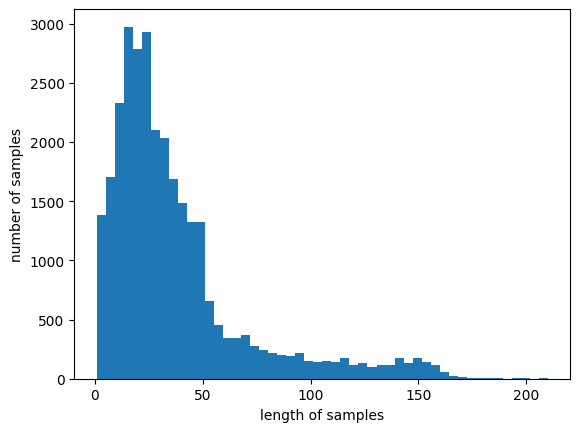

In [27]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in df_train['text']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['text']))/len(df_train['text']))
plt.hist([len(review) for review in df_train['text']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

max_length = 64

word piece시작

In [28]:
# WordPiece 토큰화를 위한 사전 훈련된 모델 불러오기
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [29]:
#기존 인덱스를 지우면서 리셋한다.
df_train.reset_index(drop=True)

,text,sentiment
0,아 더빙 진짜 짜증나네요 목소리,0
1,막 걸음 마 뗀 세 부터 초등학교 학년 생인 살용 영화 ㅋㅋㅋ 별 반개 도 아까 움,0
2,걍 인피니트 가 짱 이다 진짜 짱 이다,1
3,ㄱ 냥 매번 긴장 되고 재밋음 ㅠㅠ,1
4,나름 심오한 뜻 도 있는 듯 그냥 학생 이 선생 과 놀아나는 영화 는 절대 아님,1
...,...,...
29769,무지 자극 적 에 로 틱 드라마,1
29770,아 진짜 웃긴다 프랑스 영화 정말 싫어했었는데 이 영화 는 열 외,1
29771,해석 하기 나름 인 패륜 영화 그래도 이건 아니잖니,0
29772,이 걸 영화 라고 찎었 냐,0


In [30]:
#전처리 함수정의
# df_train['text'].tolist() 리스트형태로 들어간다

train_encodings = tokenizer(df_train['text'].tolist(), truncation=True, padding=True, max_length=max_length) 



In [ ]:
train_encodings.input_ids

In [32]:
# 입력 데이터로 변환
train_input_ids = np.array(train_encodings['input_ids'])
train_attention_mask = np.array(train_encodings['attention_mask'])
train_token_type_ids = np.array(train_encodings['token_type_ids'])

train_labels = np.array(df_train['sentiment'].tolist())



하나의 텍스트에 대한 텍스트 분류 유형(Single Text Classification)\
![버트구조](https://wikidocs.net/images/page/115055/apply1.PNG)

In [33]:
from transformers import BertConfig, TFBertModel,TFDistilBertForSequenceClassification
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# BERT 모델 불러오기
config = BertConfig.from_pretrained(
    "distilbert-base-multilingual-cased",
    # vocab_size=35000,
    hidden_size=256,
    num_hidden_layers=8, 
    num_labels=2, 
    num_attention_heads=6,
    hidden_dropout_prob=0.5,
    # max_position_embeddings=max_length
    
)
bert_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased",config=config)


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream ta

In [34]:

# 입력 정의 
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")


# BERT 출력 얻기
bert_output = bert_model(input_ids, attention_mask=attention_mask)
sequence_output = bert_output[0]

# 커스텀 레이어 정의
x = Dense(64, activation='relu')(sequence_output)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
output = Dense(2, activation='softmax')(x)

# 모델 생성
custom_bert_model = Model(inputs=[input_ids, attention_mask], outputs=output)



In [35]:
bert_model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 134734080 
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 135,326,210
Trainable params: 135,326,210
Non-trainable params: 0
_________________________________________________________________


In [38]:
# 컴파일
custom_bert_model.compile(
    optimizer=Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

# 모델 학습
custom_bert_model.fit(
    [train_input_ids, train_attention_mask],
    train_labels,
    batch_size=32, epochs=10, validation_split=0.25, 
    callbacks=[early_stop]
)

Epoch 1/10
698/698 [==============================] - 154s 158ms/step - loss: 0.1460 - accuracy: 0.9500 - val_loss: 0.6146 - val_accuracy: 0.8254
Epoch 2/10
698/698 [==============================] - 79s 113ms/step - loss: 0.1137 - accuracy: 0.9622 - val_loss: 0.6622 - val_accuracy: 0.8169
Epoch 3/10
698/698 [==============================] - 77s 111ms/step - loss: 0.0984 - accuracy: 0.9670 - val_loss: 0.6098 - val_accuracy: 0.8197
Epoch 4/10
698/698 [==============================] - 76s 108ms/step - loss: 0.0822 - accuracy: 0.9725 - val_loss: 0.7610 - val_accuracy: 0.8201
Epoch 5/10
698/698 [==============================] - 77s 110ms/step - loss: 0.0771 - accuracy: 0.9731 - val_loss: 0.7453 - val_accuracy: 0.8150
Epoch 6/10
698/698 [==============================] - 76s 108ms/step - loss: 0.0622 - accuracy: 0.9795 - val_loss: 0.7377 - val_accuracy: 0.8212
Epoch 7/10
698/698 [==============================] - 74s 107ms/step - loss: 0.0581 - accuracy: 0.9800 - val_loss: 0.7629 - val_a

In [60]:
from transformers import TextClassificationPipeline
# 예측용 파이프라인 생성
pipeline = TextClassificationPipeline(model=custom_bert_model, tokenizer=tokenizer, framework="tf")



AttributeError: ignored

In [56]:
# 예측 예시
example_texts = ['회식끝나고 집가는중','개꿀잼이네','진짜 너무 별로다.','ㅋㅋㅋㅋㅋㅋㅋㅋ재밌따','나는 잘봤다.']
#정제
clean_test_texts=[]
for i in example_texts:
    clean_test_texts.append(clean_korean_text(i))


clean_test_texts

['회식끝나고 집가는중', '개꿀잼이네', '진짜 너무 별로다', 'ㅋ재밌따', '나는 잘봤다']

In [58]:
#정제된 텍스트를 벡터화하기전에 토큰화한다
from konlpy.tag import Okt
mecab=Okt()

clean_test_texts1 = [ mecab.morphs(i) for i in clean_test_texts]
print(clean_test_texts1)

clean_test_texts2=[]
for i in clean_test_texts1:
    clean_test_texts2.append(' '.join(i))
print(clean_test_texts2)

[['회식', '끝나고', '집가는', '중'], ['개꿀잼', '이네'], ['진짜', '너무', '별로', '다'], ['ㅋ', '재밌', '따'], ['나', '는', '잘', '봤다']]
['회식 끝나고 집가는 중', '개꿀잼 이네', '진짜 너무 별로 다', 'ㅋ 재밌 따', '나 는 잘 봤다']


In [59]:
predicted = pipeline(clean_test_texts2)
print("Prediction:", predicted)

NameError: ignored

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#테스트문장 입력
test = ['회식끝나고 집가는중','개꿀잼이네','진짜 너무 별로다.','ㅋㅋㅋㅋㅋㅋㅋㅋ재밌따']

#정제
clean_test_texts=[]
for i in test:
    clean_test_texts.append(clean_korean_text(i))

max_length = 64
# 텍스트 데이터 토큰화
tokenized_test_texts = [tokenizer.encode(text, max_length=max_length, pad_to_max_length=True) for text in clean_test_texts]
tokenized_test_texts

# 토큰화된 텍스트를 Numpy 배열로 변환
tokenized_test_texts = np.array(tokenized_test_texts)
tokenized_test_texts

#벡터화
x_test = pad_sequences(tokenized_test_texts,padding='post',maxlen=max_length) 

#예측
prediction = model.predict(x_test)  

for i in np.round(prediction):
    print(int(i))

1/1 [==============================] - 1s 561ms/step
0
1
0
1


# 서비스 테스트

In [ ]:
#모델 불러오기
from tensorflow.keras.models import load_model
loaded_model= load_model('./wordpiece_test.h5')

# #저장된 vectorizer 불러오기
# import pickle
# with open('./lstm_tokenizer.pkl', 'rb') as f:
#     loaded_test_vectorizer = pickle.load(f)

In [ ]:
# 카톡대화 불러와서 정제,(정규화코드)하는 함수
import re

def get_from_txt(txt):
    data= open(txt,"r", encoding='utf-8').read().split('\n')
    sentences=[]
    for line in data:
        pattern = r'\[(.*?)\]\s+\[(.*?)\]\s+(.+)'
        match = re.match(pattern, line)
        if match:
            name = match.group(1)  # 첫 번째 대괄호 안의 단어 추출
            time = match.group(2)  # 두 번째 대괄호 안의 단어 추출
            content = match.group(3)  # 대괄호 뒤의 내용 추출
            # print(name, time, content)
            temp=[name,time,content]
            sentences.append(temp)    
    return sentences

#함수확인
get_from_txt('sample.txt')

[['김찬란', '오후 10:01', '사진'],
 ['김찬란', '오후 9:38', 'https://youtube.com/watch?v=o1G7DWFFHso&feature=share'],
 ['김찬란', '오후 10:42', '사진'],
 ['김찬란', '오후 10:42', '사기치고다니는 한장규'],
 ['김하영', '오후 10:45', '이야'],
 ['김하영', '오후 10:46', '게임에서도 치네'],
 ['김찬란', '오후 10:46', '진짜 니말이 맞다 진짜 친구면 친구한테 민폐되기 싫어서 돈빌려달란 소리도 안한다'],
 ['김하영', '오전 12:25', '이모티콘'],
 ['김하영', '오전 12:35', '회식끝나고 집가는중'],
 ['김찬란', '오전 12:35', '음음 초밥집 회식은 어디서 하냐'],
 ['김하영', '오전 12:35', '우리 실장형네 직이 고기집해서 글로갔다'],
 ['김하영', '오전 12:36', '회식하면 맨날 돼지고기만 먹는다'],
 ['김찬란', '오전 12:36', 'ㅋㅋㅋㅋㅋㅋ케'],
 ['김하영', '오전 12:36', '이모티콘'],
 ['김찬란', '오전 12:36', '아 내수용 회식'],
 ['김찬란', '오전 12:36', '사진'],
 ['김하영', '오전 12:36', 'ㅋㅋㅋㅋ 그런거 아니고 애들이 여기가 맛있다고 여기서먹음'],
 ['김찬란', '오전 12:37', '고기 얘시하니까'],
 ['김찬란', '오전 12:37', '나도 고기가 먹고 싶군'],
 ['김하영', '오전 12:37', 'ㅋㅋㅋㅋ '],
 ['김찬란', '오전 12:37', '낼 사먹어야겠다'],
 ['김하영', '오전 12:37', '와라 엉아가 소고기 사줄께'],
 ['김찬란', '오전 12:37', '내가 사야지 씹새야 입벌려'],
 ['김찬란', '오전 12:37', '고기 들어간'],
 ['김찬란', '오전 12:38', '너는 내가 사주고 싶으니까 '],
 ['김찬란', '오전 12:38', '취직해서

In [ ]:
#닉네임 입력단 
# target_name = str(input())
target_name = '김하영'
print(target_name)  #김하영 입력

김하영


In [ ]:
# 저장된 모델 불러오기
# from tensorflow.keras.models import load_models
# model= load_models('4_6_DNN 토큰화수정.h5')


#입력된 이름의 '대화내역만' 담기
received_texts= []
for i in get_from_txt('sample.txt'): 
    if i[0] == target_name:
        received_texts.append( i[2] )
        
# 이모티콘, 사진, 샵검색 제거 
clean_received_texts2 = []
for i in received_texts:
    if '샵검색:' not in i: 
        if "이모티콘" not in i:
            if '사진' not in i:
                clean_received_texts2.append(str(i))

#=========== 이쯤에서 답장시간 계산기 구현   =======================
          
          
#텍스트 정제  
clean_received_texts2= [clean_korean_text(i) for i in clean_received_texts2]
clean_received_texts2

# 텍스트 데이터 토큰화
tokenized_test_texts = [tokenizer.encode(text, max_length=max_length, pad_to_max_length=True) for text in clean_received_texts2]
tokenized_test_texts

# 토큰화된 텍스트를 Numpy 배열로 변환
tokenized_test_texts = np.array(tokenized_test_texts)
tokenized_test_texts

# 벡터데이터 변환
x_test = pad_sequences(tokenized_test_texts,padding='post',maxlen=64) 

# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(x_test)
#예측 결과 출력 (긍정: 1, 부정: 0)
print(predictions.squeeze().tolist()) #차원을 축소하고 리스트객체로 변환

cnt0=0;cnt1=0; cnt2=0
for i in predictions.squeeze().tolist():
    if i <= 0.45:
        cnt0+=1
    elif i >= 0.55:
        cnt1+=1
    else :
        cnt2+=1
        
#부정과 긍정문의 갯수
print('부정문과 긍정문의 갯수:',cnt0,cnt1)
print('중립문장의 갯수:',cnt2)

#긍정과 부정의 비율( 긍정문의 수 / 부정문의 수)
print('긍정과 부정의 비율: ',cnt1/cnt0)
#숫자가 1이상이고 높을수록 긍정적이다.

6/6 [==============================] - 0s 7ms/step
[0.42015233635902405, 0.15778325498104095, 0.4034382998943329, 0.15830516815185547, 0.2756638824939728, 0.23274767398834229, 0.5671480298042297, 0.25340867042541504, 0.4362293481826782, 0.4002711772918701, 0.6111466884613037, 0.06004936248064041, 0.1837492287158966, 0.1312265843153, 0.2406095564365387, 0.08809877932071686, 0.3380661606788635, 0.17884549498558044, 0.544122040271759, 0.5671480298042297, 0.3253222107887268, 0.34540876746177673, 0.34540876746177673, 0.4286506474018097, 0.5671480298042297, 0.28317803144454956, 0.5671480298042297, 0.11938949674367905, 0.4006653428077698, 0.19541098177433014, 0.12212876230478287, 0.31381163001060486, 0.3801400661468506, 0.3815697431564331, 0.5671480298042297, 0.4159267246723175, 0.4814023971557617, 0.3980425298213959, 0.24305537343025208, 0.3207646906375885, 0.12008189409971237, 0.32288381457328796, 0.5671480298042297, 0.5671480298042297, 0.42395874857902527, 0.4516054093837738, 0.19916307926

In [ ]:
clean_received_texts2